## Instalando o ambiente necessário

In [27]:
!pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=8a524ecd1f354589fc372bf21c047c5f165d152488b80446f68c27ec1d8a2121
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [1]:
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0  11843      0 --:--:-- --:--:-- --:--:-- 11843
OK


In [15]:
!curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    77  100    77    0     0   1166      0 --:--:-- --:--:-- --:--:--  1166


In [16]:
!apt-get update

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:5 https://packages.microsoft.com/ubuntu/18.04/prod bionic InRelease [4,002 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 https://packa

In [13]:
#!apt-get remove msodbcsql17

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  unixodbc
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  msodbcsql17
0 upgraded, 0 newly installed, 1 to remove and 35 not upgraded.
After this operation, 0 B of additional disk space will be used.
(Reading database ... 144424 files and directories currently installed.)
Removing msodbcsql17 (17.5.2.1-1) ...


In [14]:
#!apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  unixodbc
0 upgraded, 0 newly installed, 1 to remove and 35 not upgraded.
After this operation, 114 kB disk space will be freed.
(Reading database ... 144407 files and directories currently installed.)
Removing unixodbc (2.3.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [17]:
!ACCEPT_EULA=Y apt-get install msodbcsql17

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  unixodbc
The following NEW packages will be installed:
  msodbcsql17 unixodbc
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 775 kB of archives.
After this operation, 114 kB of additional disk space will be used.
Get:1 https://packages.microsoft.com/ubuntu/18.04/prod bionic/main amd64 unixodbc amd64 2.3.7 [19.6 kB]
Get:2 https://packages.microsoft.com/ubuntu/18.04/prod bionic/main amd64 msodbcsql17 amd64 17.5.2.1-1 [755 kB]
Fetched 775 kB in 0s (9,119 kB/s)
Preconfiguring packages ...
Selecting previously unselected package unixodbc.
(Reading database ... 144402 files and directories currently installed.)
Preparing to unpack .../unixodbc_2.3.7_amd64.deb ...
Unpacking unixodbc (2.3.7) ...
Selecting previously unselected package msodbcsql17.
Preparing to unpack .../msodbcsql17_17.5.2.1-1_amd64.deb ...
Unpacking

In [9]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [19]:
!sudo apt-get install unixodbc-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unixodbc-dev
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 37.1 kB of archives.
After this operation, 1,739 kB of additional disk space will be used.
Get:1 https://packages.microsoft.com/ubuntu/18.04/prod bionic/main amd64 unixodbc-dev amd64 2.3.7 [37.1 kB]
Fetched 37.1 kB in 0s (645 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package unixodbc-dev.
(Reading database ... 144423 fil

In [20]:
!pip install pyodbc


  Using cached https://files.pythonhosted.org/packages/81/0d/bb08bb16c97765244791c73e49de9fd4c24bb3ef00313aed82e5640dee5d/pyodbc-4.0.30.tar.gz
  Created wheel for pyodbc: filename=pyodbc-4.0.30-cp36-cp36m-linux_x86_64.whl size=272713 sha256=af092915cd4327c823207c540705413d6ccafd676145bacd1135b0e48c93a604
  Stored in directory: /root/.cache/pip/wheels/4a/02/ba/6b495fec7cb127583a769a74f3ba91eb700d73e25fbb5ba09b
Successfully built pyodbc


## Importações e configurações gerais

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.dates as mdates

from datetime import datetime
import datetime
from datetime import timedelta

import random

from mlxtend.plotting import ecdf
import powerlaw

from sklearn import metrics
import itertools


In [0]:
def setSeabornStyle(style='Default'):
    if (style == 'Dark'):
        #sns.set(style="ticks", palette='dark')
        sns.set(style="ticks")
        sns.set_palette(sns.xkcd_palette(["windows blue"])+sns.color_palette('Set2', 4)+sns.xkcd_palette(["amber", "greyish", "faded green", "dusty purple"]))
    else:
        #sns.set(style="ticks", palette='Pastel1')
        sns.set(style="ticks")
        sns.set_palette(sns.color_palette(["#A576B6", "#58A7DC"])+sns.color_palette('Set2', 8))

In [0]:
def fitDistribution(x1, x_min=None):
    if (x_min != None):
        fit = powerlaw.Fit(np.array(x1), discrete=True, xmin=x_min)
    else:
        fit = powerlaw.Fit(np.array(x1), discrete=True)
    fit.power_law.alpha
    fit.power_law.sigma

    #para ver as distribuições possíveis
    #fit.supported_distributions
    distributions = ['exponential','lognormal','lognormal_positive','stretched_exponential','truncated_power_law']


    for dist in distributions:
        t = fit.distribution_compare('power_law', dist, normalized_ratio=True)
        print("({2}, {0:12.12f}, {1:12.12f})".format(t[0], t[1], dist))
        
    return fit;

In [0]:
#import sys
#print(sys.version)

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:20,.2f}'.format

np.set_printoptions(suppress=True)



contrastColorPallete = ['#998ec3', '#f1a340', '#f7f7f7']
paleta = sns.color_palette("Pastel1", 20)
setSeabornStyle()

size_p = 4
size_g = 8
size_xg = 12
size_xxg = 16

line_size=0.4

pd.set_option('display.max_columns', 500)


## Acesso ao banco de dados

In [0]:

import pyodbc
import json


with open('/content/drive/My Drive/Colab Notebooks/sql_credentials.json') as f:
    data = json.load(f)
    username = data['userName']
    password = data['userPassword']
    server = data['server']
    database = "db_strava"


driver= '{ODBC Driver 17 for SQL Server}'
conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
    


In [0]:
query = """
select (select count(*)
        from community_membership c where c.community = ac.community and c.algorithm = ac.algorithm
        group by community, algorithm) as size,
       algorithm, community
from answer_community ac
"""

df = pd.read_sql(query, conn)



Text(0.5, 1.0, 'distribuição das respostas por comunidade')

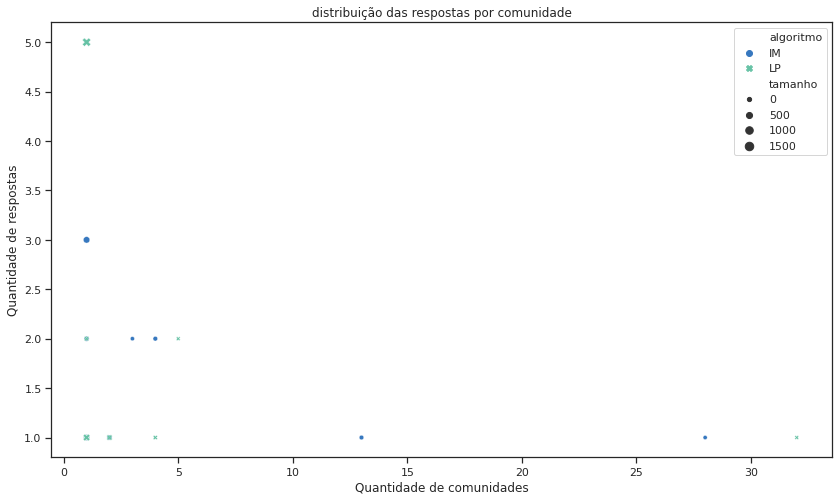

In [33]:
setSeabornStyle('Dark')
plt.figure(figsize=(14,8))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)

#plt.subplot(1,1,1)


df['answers'] = 0
df['size'] = (df['size']/100).astype(int)
df['size'] = (df['size'] * 100).astype(int)
df = df.groupby(['community','size', 'algorithm'], as_index = False).count()
#arredonda por centenas
#t['size'] = t['size']/100
df = df.groupby(['answers','size', 'algorithm'], as_index = False).count()
df.rename(inplace=True, columns={"size": "tamanho"})
df.rename(inplace=True, columns={"answers": "respostas"})
df.rename(inplace=True, columns={"community": "comunidades"})
df.rename(inplace=True, columns={"algorithm": "algoritmo"})


g = sns.scatterplot(x="comunidades", y="respostas", hue="algoritmo", style="algoritmo", size='tamanho', data=df, linewidth=line_size)
#g.set(yscale='log')
#g.set(xscale='log')
g.set_ylabel('Quantidade de respostas')
g.set_xlabel('Quantidade de comunidades')


plt.title('distribuição das respostas por comunidade')

#t = None

### Comunidades com pelo menos 3 respostas

In [34]:
df[df['respostas'] > 2].groupby(['algoritmo', 'respostas'], as_index = False).count().rename(inplace=False, columns={"tamanho": "quantidade"})


,algoritmo,respostas,quantidade,comunidades
0,IM,3,3,3
1,IM,5,1,1
2,LP,3,2,2
3,LP,5,2,2


In [35]:
df = pd.read_sql(query, conn)
df['qtd'] = 0
df = df.groupby(['size', 'algorithm', 'community'], as_index = False).count()
df[df['qtd'] > 2]

,size,algorithm,community,qtd
18,17,LP,35,3
80,157,IM,123,5
92,196,LP,34,5
99,341,IM,23,3
100,396,LP,728,3
104,588,IM,5,3
106,653,IM,3,3
108,1467,LP,242,5
